In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Custom utility methods
from src.EvaluateModels import EvaluatePreprocessors, EvaluateEstimators, EvaluatePipelines
from src.model_utils import make_categorical_encoding, plot_learning_curve, plot_validation_curve

# Models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Pipelines and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest

# Model selection and metrics
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn import set_config
set_config(display = 'diagram')


# Dev - load extension to autoreload when imported code from src changes
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [2]:
train_df = pd.read_csv('../data/processed/training_data.csv', index_col = 0)
target = train_df.salary
train_df.drop(columns = 'salary', inplace=True)

In [3]:
train_df

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
58414,JUNIOR,HIGH_SCHOOL,NONE,WEB,14,84
902618,SENIOR,MASTERS,COMPSCI,SERVICE,24,86
778824,JANITOR,NONE,NONE,WEB,4,86
187593,SENIOR,HIGH_SCHOOL,NONE,WEB,0,42
574438,VICE_PRESIDENT,MASTERS,BUSINESS,AUTO,16,97
...,...,...,...,...,...,...
259179,VICE_PRESIDENT,DOCTORAL,BUSINESS,OIL,9,93
365839,CFO,DOCTORAL,BUSINESS,HEALTH,15,88
131933,SENIOR,MASTERS,COMPSCI,HEALTH,18,42
671158,SENIOR,DOCTORAL,PHYSICS,SERVICE,5,23


## Variables

In [4]:
# Specify ordinal levels for categorical variables
jobtype_ord_levels = ['JANITOR', 'JUNIOR',  'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO']
degree_ord_levels = ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL']
# industry levels ordered from lowest average salary to highest
industry_ord_levels = ['EDUCATION', 'SERVICE', 'AUTO', 'HEALTH', 'WEB', 'FINANCE', 'OIL']

# Scoring metric for modeling
SCORING_METRIC = 'neg_mean_squared_error'

# Basic Model - Linear Regression

I want to start modeling with something a little more basic and see how a linear regression measures up to the best baseline score that was found without ML.

**Best baseline score (MSE):** `371.22`

Plan:
1. Encode categorical variables
    - Ordinal encoding for `jobType` and `degree` variables
    - One hot encoding for `industry` and `major` variables
2. Scale numeric variables
    - use StandardScaler for `yearsExperience` and `milesFromMetropolis`
    
Starting out treating `jobType` and `degree` as ordinal. Depending on how the scores measure up, I can try other encodings and preprocessing. 

In [5]:
# Preprocessing with ColumnTransformer
basic_lr_preprocessing = ColumnTransformer([
    ('ordinal_encoding', OrdinalEncoder(categories=[jobtype_ord_levels, degree_ord_levels]), ['jobType', 'degree']),
    ('one_hot_encoding', OneHotEncoder(), ['major', 'industry']),
    ('std_scaler', StandardScaler(), ['yearsExperience', 'milesFromMetropolis'])
], remainder='passthrough')

# Model pipeline
basic_lr_model = Pipeline([
    ('preprocess', basic_lr_preprocessing),
    ('linear regression', LinearRegression())
])
basic_lr_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(categories=[['JANITOR',
                                                                              'JUNIOR',
                                                                              'SENIOR',
                                                                              'MANAGER',
                                                                              'VICE_PRESIDENT',
                                                                              'CFO',
                                                                              'CTO',
                                                                              'CEO'],
                                                                             ['NONE',
                                                                              'HIGH_SCHOOL',
                                                                              'BACHELORS',
                                                                              'MASTERS',
                                                                              'DOCTORAL']]),
                                                  ['jobType', 'degree']),
                                                 ('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['major', 'industry']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis'])])),
                ('linear regression', LinearRegression())])

In [6]:
# Run cross validation
basic_lr_scores = cross_validate(basic_lr_model, train_df, target, cv = 5, scoring = SCORING_METRIC, return_train_score = True)

print(f"Mean test score: {np.mean(basic_lr_scores['test_score'])}", end = '\n\n')
basic_lr_scores

Mean test score: -394.38290117364784



{'fit_time': array([1.54572606, 1.46879983, 1.50775766, 1.51774693, 1.50826216]),
 'score_time': array([0.19527698, 0.18928695, 0.20127082, 0.20326424, 0.20975423]),
 'test_score': array([-393.30608198, -396.3105107 , -394.56362714, -395.18530224,
        -392.54898381]),
 'train_score': array([-394.63886445, -393.88634722, -394.32206648, -394.16714741,
        -394.82603238])}

This linear regression's error is quite a bit higher than our best baseline score. I wonder if changing the encoding of the categorical variables will impact the results in a positive way.

## Test different categorical encodings

**Plan:**  
Test modeling different variables as ordinal encoding, and also test all one hot encoding

Candidates for ordinal encoding:
- jobType
- degree
- industry

`jobType` and `degree` I think are the ones that can be argued to have the most natural precedent for an ordering. 
- The different levels of `jobType` can be interpreted as needing different levels of: experience, qualifications, or responsibility on the job. (i.e. especially between the levels 'junior', 'senior', 'manager').
- Similarly with `degree` the natural ordering can be interpreted as the number of years of schooling. In this case it makes sense to order the levels as: `'none' < 'high school' < 'bachelors' < 'masters' < 'doctoral'`

As far as `industry` is concerned, it may be valid to argue that there is no real natural ordering between industries; can you really rank health versus finance industries? But the average salary of each of the levels of `industry` seem more spread out and cover a wider range of values than `degree`. So I can use the data to give a guess as to the order - might as well try it out.

I don't think it makes sense for `major` to be treated as ordinal here. Because there isn't a clear natural ording to the different majors. Additionally, there is no real data to give a direction at guessing/imposing an order on the levels of `major`. The average salary for the subgroups of `major` are too close together, plus the distributions of the salary for each of the levels of `major` are very much overlapped. And even during EDA we saw that top paying salaries across different industries have different majors, so it is hard to think of an ordering.
- I will only treat `major` as a nominal variable and use one hot encoding


**Preprocessing pipelines to test:**
1. Single ordinal encoding  
    a. jobType  
    b. industry  
    c. degree  
2. Double ordinal encoding  
    a. jobType & industry  
    b. industry & degree  
3. All 3 ordinal encoding
4. All one hot
5. First model (degree & jobType as ordinal)

In [6]:
# Keep a dictionary so that I can easily refer back to these column transformers later if necessary
# But I will also make a list of tuples to be fed into the evaluator classes 
categorical_encoding_pipelines = {
    # single ordinal encoding
    'jobType_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels],
                                                 ord_cols = ['jobType'],
                                                 oh_cols = ['industry', 'degree', 'major']),
    'industry_ordinal': make_categorical_encoding(category_levels = [industry_ord_levels],
                                                  ord_cols = ['industry'],
                                                  oh_cols = ['jobType', 'degree', 'major']),
    'degree_ordinal': make_categorical_encoding(category_levels = [degree_ord_levels],
                                                ord_cols = ['degree'],
                                                oh_cols = ['industry', 'jobType', 'major']),
    
    # double ordinal encoding
    'jobType-industry_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels, industry_ord_levels],
                                                          ord_cols = ['jobType', 'industry'],
                                                          oh_cols = ['degree', 'major']),
    'industry-degree_ordinal': make_categorical_encoding(category_levels = [industry_ord_levels, degree_ord_levels],
                                                         ord_cols = ['industry', 'degree'],
                                                         oh_cols = ['jobType', 'major']),
    
    # All 3 ordinal 
    'all_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels, industry_ord_levels, degree_ord_levels],
                                             ord_cols = ['jobType', 'industry', 'degree'],
                                             oh_cols = ['major']),
    
    # All one hot
    'all_one_hot': make_categorical_encoding(category_levels = None, ord_cols = None,
                                             oh_cols = ['jobType', 'degree', 'industry', 'major']),
    
    # First model - basic lr (jobType & degree ordinal) 
    'basic_lr_(first model)': basic_lr_preprocessing
    
}

# list of test arrays
categorical_encoding_list = [(name, transformer) for name, transformer in categorical_encoding_pipelines.items()]

In [8]:
find_best_categorical_encoding = EvaluatePreprocessors(preprocessors = categorical_encoding_list,
                                                       estimator = LinearRegression(),
                                                       scoring = SCORING_METRIC)

find_best_categorical_encoding.run(train_df, target)

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Best model found:
Pipeline(steps=[('all_one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis'])])),
                ('estimator', LinearRegression())])

Model score (using 'neg_mean_squared_error')
-384.40224675582164



,test_score,train_score,fit_time,score_time
all_one_hot,-384.402247,-384.377823,1.412372,0.209958
degree_ordinal,-384.580781,-384.557766,1.410672,0.221447
industry_ordinal,-386.794762,-386.774068,1.485694,0.215850
industry-degree_ordinal,-386.973211,-386.953954,1.442635,0.215551
jobType_ordinal,-394.090058,-394.073960,1.441339,0.222244
basic_lr_(first model),-394.382901,-394.368092,1.517460,0.200868
jobType-industry_ordinal,-396.491995,-396.478983,1.471216,0.208557
all_ordinal,-396.784029,-396.772258,1.293513,0.190380


The categorical encoding that worked the best is using one hot for all the variables, with a score of `384.40`. But this is still not quite as low as the baseline score.

# Test other models

**Plan:**  
Explore how other models, with basic parameter settings, measure up to the linear regression model. Before diving into getting better performance out of the linear regression model I will see if there is another type of model which seems to greatly outperform the rest, and could be more fruitful to spend time on.

**Models to test:**
- SDGRegressor
    - The linear regression seems to have more of a bias than variance issue, this may be able to fit the data better
- Random forest
- XGBoost gradient boosted trees

#### New categorical encoding to help for tree based methods
After an initial test with random forest, using all one hot encoding seems to have a negative effect on performance in terms of training time and MSE.

This encoding uses the default OrdinalEncoder labeling and doesn't scale the `yearsExperience` or `milesFromMetropolis`.

In [7]:
ordinal_no_scaling_pp = ColumnTransformer([('ordinal encoding', OrdinalEncoder(), ['jobType', 'degree', 'industry', 'major'])], remainder = 'passthrough')
ordinal_no_scaling_pp

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal encoding', OrdinalEncoder(),
                                 ['jobType', 'degree', 'industry', 'major'])])

In [8]:
# New models
random_forest = Pipeline([
    ('categorical_encoding', ordinal_no_scaling_pp),
    ('rf', RandomForestRegressor(max_depth = 20, n_estimators = 150, n_jobs = -1, min_samples_leaf = 10))
])

xg_boost = Pipeline([
    ('categorical_encoding', categorical_encoding_pipelines['all_one_hot']),
    ('xbg', XGBRegressor())
])

sgd_regressor = Pipeline([
    ('categorical_encoding', categorical_encoding_pipelines['all_one_hot']),
    ('sgd_regressor', SGDRegressor())
])

new_model_pipelines = [
    ('rf', random_forest),
    ('xgb', xg_boost),
    ('sgd_regressor', sgd_regressor)
]

In [43]:
test_new_models = EvaluatePipelines(new_model_pipelines, scoring = SCORING_METRIC)
test_new_models.run(train_df, target, verbose = True)

------------------------------
Finished training: rf
Test score  : -375.3301843570048
Train score : -302.6059283697493

------------------------------
Finished training: xgb
Test score  : -358.49743819860595
Train score : -352.25551074759744

------------------------------
Finished training: sgd_regressor
Test score  : -384.5905336575519
Train score : -384.57045782847615

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Best model found:
Pipeline(steps=[('categorical_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                              

,test_score,train_score,fit_time,score_time
xgb,-358.497438,-352.255511,21.978652,0.355188
rf,-375.330184,-302.605928,71.441053,2.132487
sgd_regressor,-384.590534,-384.570458,5.667595,0.210059


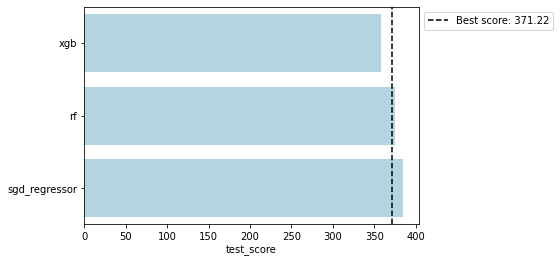

In [45]:
# Plot the results with a reference to the best score before this test (baseline score)
test_new_models.plot_results(best_score = 371.22)

**Results:**
- xgboost: 
    - Performed the best on the validation set
    - Pretty reasonable train time, which means parameter tuning should be quicker than random forest.
    - Has some variance that should be paid attention to with further parameter tuning.
- randomforest: 
    - Fits the training data better and has a bit of a variance/ overfitting issue. But with some regularization it may generalize well.
    - Has a longer train time, and might take awhile to comprehensively parameter tune.
- SGDRegressor:
    - About the same error as linear regression. Has more of a bias problem than variance, so tweaking the regularization parameters will probably not help as much here.
    - Still doesn't beat the baseline score. Perhaps with some more training iterations, but this model doesn't seem as fruitful to spend time on over the other two.

# Randomforest

**Plan:**  
Explore regularization options to reduce variance and hopefully improve cross validation scores.

## Learning curve

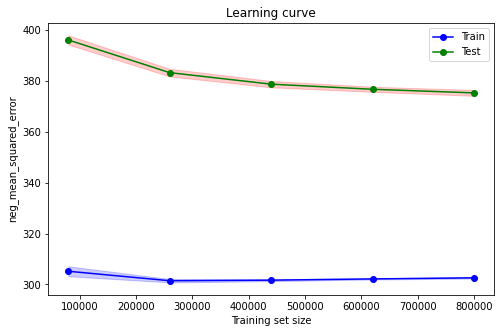

In [46]:
plot_learning_curve(random_forest, train_df, target, scoring = SCORING_METRIC)

It doesn't look like reducing the training size (for speed purposes) will be worth it.

## Validation Curves

Since the training time is a little longer with this model, I will start looking at validation curves for individual parameter ranges instead of a grid search. So that I may be able to get quicker feedback, and narrow down some ranges of parameters that work better.

**max_depth**: Reducing the depth of the trees in the forest will make the model less complex and hopefully reduce variance

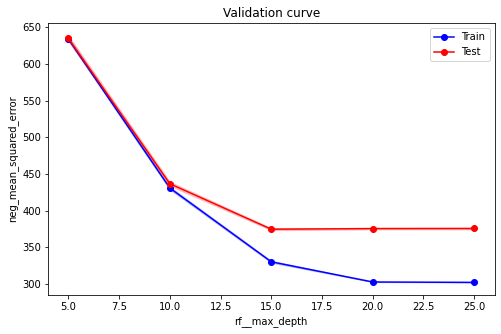

In [49]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__max_depth', param_range = [5, 10, 15, 20, 25], scoring = SCORING_METRIC)

Having a `max_depth` of greater than 15 doesn't look to make any significant difference in the test score; and having a depth greater than 20 doesn't look to make a difference for the training scores.

**min_samples_leaf:**

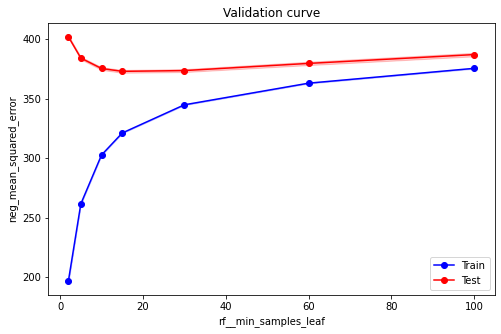

In [50]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__min_samples_leaf', param_range = [2, 5, 10, 15, 30, 60, 100], scoring = SCORING_METRIC)

**max_features:**

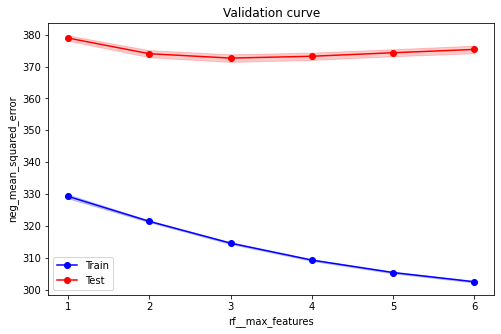

In [52]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__max_features', param_range = [1, 2, 3, 4, 5, 6], scoring = SCORING_METRIC)

**n_estimators:** reducing the number of estimators will make the model less complex

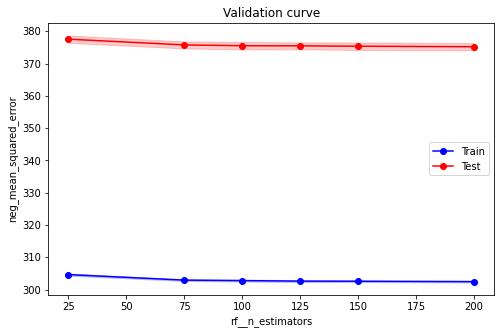

In [14]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__n_estimators', param_range = [25, 75, 100, 125, 150, 200], scoring = SCORING_METRIC)

### Improved random forest

Using parameters that had lower error and variance from the validation curves

In [18]:
improved_randomforest = Pipeline([
    ('categorical_encoding', ordinal_no_scaling_pp),
    ('rf', RandomForestRegressor(max_depth = 15, n_estimators = 150, n_jobs = -1, min_samples_leaf = 25))
])

cross_validate(improved_randomforest, train_df, target, scoring = SCORING_METRIC, return_train_score = True, cv = 5)

{'fit_time': array([64.09051585, 64.23023486, 63.2505455 , 65.29251957, 68.26183629]),
 'score_time': array([1.16629076, 1.08400178, 1.17319274, 1.29433751, 1.18028998]),
 'test_score': array([-373.69125902, -377.11214517, -374.91815775, -374.57541448,
        -372.97761755]),
 'train_score': array([-347.1606606 , -347.15908243, -345.30680722, -344.87559962,
        -346.67850941])}

In [19]:
# max_depth = 15, n_estimators = 150, n_jobs = -1, min_samples_leaf = 25 
# test scores from above cross_validation
np.mean([-373.69125902, -377.11214517, -374.91815775, -374.57541448, -372.97761755])

-374.65491879399997

We have slightly improved the MSE from `375.33` to `374.65` MSE. But based on the validation curve plots, it doesn't look too promising to get below 370 MSE on the test set. A better score could be found through extensive grid search. But with the longer fitting time, I think exploring the xgboost model for improvements would be a better use of time.

# XGBoost

**Plan:**  
Before hyperperameter tuning I want to test out the categorical encoding that worked best with random forest. 

The first run of xgboost that scored 358.5 MSE used all one hot encoding for the categorical variables. I saw that scores (and training time) improved  when I didn't use one hot encoding with random forest, and since the base model of xgboost is a decision tree, maybe I can improve the score with just the preprocessing step.

In [13]:
xgboost_preprocessing = [
    ('first_xgboost', categorical_encoding_pipelines['all_one_hot']),
    ('ord_xgboost', ordinal_no_scaling_pp)
]

In [14]:
test_xgb_preprocessing = EvaluatePreprocessors(preprocessors = xgboost_preprocessing,
                                               estimator = XGBRegressor(),
                                               scoring = SCORING_METRIC)
test_xgb_preprocessing.run(train_df, target)

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Best model found:
Pipeline(steps=[('ord_xgboost',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  OrdinalEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, gamma=None, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                             

,test_score,train_score,fit_time,score_time
ord_xgboost,-358.487518,-353.232524,20.507301,0.259007
first_xgboost,-358.497438,-352.255511,20.076661,0.334814


Using ordinal encoding performs slightly better and I will use it for parameter tuning.

In [18]:
xgboost_ord_model = Pipeline([
    ('categorical_encoding', ordinal_no_scaling_pp),
    # tree_method = 'hist' recommended for large datasets as per documentation
    ('xgb', XGBRegressor(tree_method = 'hist'))
])

## Learning curve

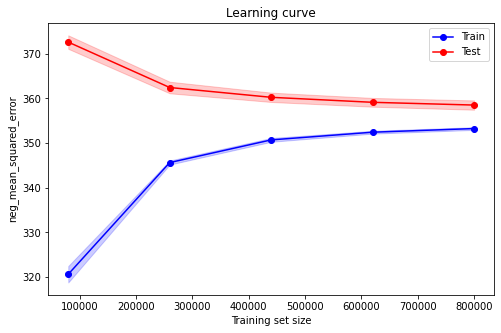

In [15]:
plot_learning_curve(xgboost_ord_model, train_df, target, scoring = SCORING_METRIC)

It looks like adding more training data wouldn't help significantly with optimizing the MSE.

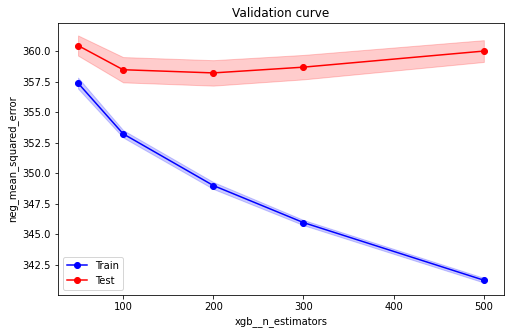

In [17]:
plot_validation_curve(xgboost_ord_model, train_df, target, param_name = 'xgb__n_estimators', param_range = [50, 100, 200, 300, 500], scoring = SCORING_METRIC)

As the estimators (boosting steps) grow past 100, the variance also continues to grow. But lowering the learning_rate in combination with increasing estimators could help. 

### Grid search

**Plan:**
Use a funnel down approach - start with wide ranges of parameters and narrow them down.

In [30]:
xgb_param_grid = {
    'xgb__n_estimators': [275, 350, 400],
    'xgb__learning_rate': [0.01, 0.1, 0.15],
    'xgb__max_depth': [6],
    'xgb__gamma': [0.0001, 0.0005, 0.001],
    'xgb__min_child_weight': [175, 200, 250]
}

xgb_grid_search = GridSearchCV(xgboost_ord_model, xgb_param_grid, scoring = SCORING_METRIC, cv = 5, n_jobs = 2)

In [31]:
xgb_grid_search.fit(train_df, target)

print(f"Best score found: {xgb_grid_search.best_score_}")
print("Best params:")
print(xgb_grid_search.best_params_)

Best score found: -356.16350804025694
Best params:
{'xgb__gamma': 0.0001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_weight': 200, 'xgb__n_estimators': 275}


### Grid Search Results
Historical log of grid search tests

- **Round 1:**
    - Tested:
    ```
    {
    'xgb__n_estimators': [75, 100, 115, 125],
    'xgb__learning_rate': [0.1, 0.25, 0.5, 0.75, 0.9],
    'xgb__max_depth': [2, 4, 6]
    }
    ```
    - Best:
    ```
    {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 125}
    ```
    - Score: `-357.14584049361605`
- **Round 2:**
    - Tested:
    ```
    {
    'xgb__n_estimators': [115, 125, 150],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [4, 6, 8, 12],
    'xgb__gamma': [0.01, 0.05, 1, 3]
    }
    ```
    - Best:
    ```
    {'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 150}
    ```
    - Score: `-356.7280836451623`
- **Round 3:**
    - Tested:
    ```
    {
    'xgb__n_estimators': [130, 150, 165],
    'xgb__learning_rate': [0.01, 0.1, 0.15],
    'xgb__max_depth': [5, 6, 7],
    'xgb__gamma': [0.001, 0.01, 0.1]
    }
    ```
    - Best:
    ```
    {'xgb__gamma': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 165}
    ```
    - Score: `-356.60186510950496`
- **Round 4:**  
max_depth and learning_rate have not changed throughout the previous steps. Will try adding a new parameter in
    - Tested:
    ```
    {
    'xgb__n_estimators': [150, 165, 225, 275],
    'xgb__learning_rate': [0.1],
    'xgb__max_depth': [6],
    'xgb__gamma': [0.0005, 0.001, 0.0015],
    'xgb__min_child_weight': [100, 150, 200, 300]
    }
    ```
    - Best: 
    ```
    {'xgb__gamma': 0.0005, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_weight': 200, 'xgb__n_estimators': 275}
    ```
    - Score: `-356.16350804025694`
- **Round 5:**
    - Tested:
    ```
    {
    'xgb__n_estimators': [275, 350, 400],
    'xgb__learning_rate': [0.01, 0.1, 0.15],
    'xgb__max_depth': [6],
    'xgb__gamma': [0.0001, 0.0005, 0.001],
    'xgb__min_child_weight': [175, 200, 250]
    }
    ```
    - Best:
    ```
    {'xgb__gamma': 0.0001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_weight': 200, 'xgb__n_estimators': 275}
    ```
    - Score: `-356.16350804025694`
    
    Round 5 found the same score and all the same parameters except gamma as round 4

In [52]:
# Set the best parameters found with grid search
xgboost_ord_model.set_params(**{'xgb__gamma': 0.0001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_weight': 200, 'xgb__n_estimators': 275})

Pipeline(steps=[('categorical_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  OrdinalEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.5, gamma=0.0001, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=None, max_depth=6,
                              min_child_weight=200, missing=nan,
                              monotone_constraints=None, n_estimators=275,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method='hist',
                              validate_parameters=None, verbosity=None))])

### Validation curve - colsample_bytree
Given the best parameters found so far, how much will sampling fewer features help?

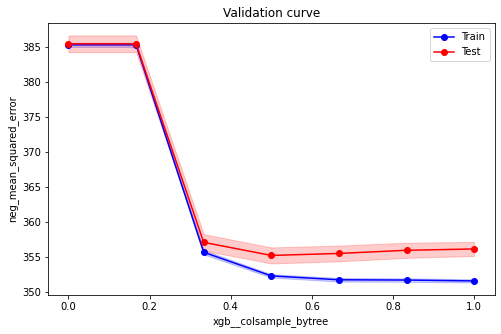

In [44]:
# use np.arange with a stepsize of 1/6 because the feature matrix has 6 features
plot_validation_curve(xgboost_ord_model, train_df, target, param_name = 'xgb__colsample_bytree', param_range = np.arange(0, 1.16, 1/6), scoring = SCORING_METRIC)

It looks like using a value of `0.5` (i.e. sampling 3/6 features for each new tree) is a good choice. Because of the relatively low error <u>*and*</u> low variance between train and test scores.

In [53]:
xgboost_ord_model.set_params(xgb__colsample_bytree = 0.5)
colsample_scores = cross_validate(xgboost_ord_model, train_df, target, scoring = SCORING_METRIC, return_train_score=True)
print(f"MSE for new model: {np.mean(colsample_scores['test_score'])}")

MSE for new model: -355.2378497636943


This does indeed result in an improvement with a MSE of `355.23`, beating the previous best score of `356.16`.

In [55]:
print(f"Average train score: {np.mean(colsample_scores['train_score'])}")
print(f"Average test score : {np.mean(colsample_scores['test_score'])}")

Average train score: -352.3223496470001
Average test score : -355.2378497636943


With the tuned model we have lowered both the error, and the variance between train and test scores.

|             |Test score|Train score|Test-train diff|
|-------------|:--------:|:---------:|:-------------:|
|First xgboost|  358.50  |  352.26   |      6.24     | 
|Tuned xgboost|  355.24  |  352.32   |      2.92     |

### Train and save best model

In [66]:
# Best model params
xgboost_ord_model.get_params()

{'memory': None,
 'steps': [('categorical_encoding',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal encoding', OrdinalEncoder(),
                                    ['jobType', 'degree', 'industry', 'major'])])),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=0.5, gamma=0.0001,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=0.1, max_delta_step=None, max_depth=6,
                min_child_weight=200, missing=nan, monotone_constraints=None,
                n_estimators=275, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method='hist',
                validate_parameters=None, verbosity=None))],
 'verbose': False,
 'categorical_encoding': ColumnTransformer(remainder='passthrou

In [69]:
xgboost_ord_model.fit(train_df, target)

Pipeline(steps=[('categorical_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  OrdinalEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major'])])),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.5, gamma=0.0001, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=6,
                              min_child_weight=200, missing=nan,
                              monotone_constraints='()', n_estimators=275,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='hist',
                              validate_parameters=1, verbosity=None))])

In [74]:
with open('../models/salary_prediction_xgboost_v1.pkl', 'wb') as file:
    pickle.dump(xgboost_ord_model, file)

In [75]:
xgboost_ord_model.predict(train_df)

array([ 79.6578  , 103.51608 ,  51.150364, ..., 132.93355 ,  98.894585,
        75.00058 ], dtype=float32)